In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals

from shapely.geometry import LineString, Point, Polygon
from sympy import RegularPolygon

import pathlib
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [23]:
def angle3d(x1,y1,z1,x2,y2,z2,x3,y3,z3):
    a = np.array([x1,y1,z1])
    b = np.array([x2,y2,z2])
    c = np.array([x3,y3,z3])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.pi - np.arccos(cosine_angle)
    return (angle)


def errorangle3d(angle, energy2, fwhm_en_perc):
    energyerr = fwhm_en_perc*energy2/2.355
    return abs(0.511*energyerr/(np.sin(angle)*((0.511-energy2)**2)))

def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame



def build_model():
    model = keras.Sequential([layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(6, activation=tf.nn.relu),
    #layers.Dense(5, activation=tf.nn.tanh),
    layers.Dense(2, activation=tf.nn.softmax)])

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Acc')
    plt.legend()
    plt.show()
    
#geometry of scanner needed for first intersection
r_min = 50.1
m_width = 13
r_eff = np.sqrt(r_min**2+(m_width/2)**2)
n_repeat = 24
poly = RegularPolygon([0, 0], r_eff, n_repeat, np.pi/(n_repeat))
polyscipy = Polygon(poly.vertices)

#TO CHECK 
def find_intersection(point1, point2, x1, x2): #point 1 is the single event, point 2 is the first candidate for compton event
    #use midpoint, else i find two intersections
    midpoint = [(point1[0]+point2[0])/2, (point1[1]+point2[1])/2]
    line = LineString([midpoint,point2])
    inters = polyscipy.intersection(line)
    #placeholder for when it does not intersect (need to investigate)
    intersection = -1
    
    if inters:
        y, z = inters.xy
        y1 = y[0]; z1 = z[0]
        y2 = y[1]; z2 = z[1]

        #intersection are the midpoint and the true intersection
        if y1 == midpoint[0] and z1 == midpoint[1]: #then y2,z2 is the true intersection
            x2int = find_x_inline(x1,point1[0],x2,point2[0],y2) #find x coordinate of intersection
            intersection = [x2int, y2, z2]
        elif y2 == midpoint[0] and z2 == midpoint[1]: #then y1,z1 is the true intersection
            x1int = find_x_inline(x2, point2[0], x1, point1[0],y1) #find x coordinate of intersection
            intersection = [x1int, y1, z1]
    return intersection

def find_x_inline(x1,y1,x2,y2,y3): #1 is single (point1), 2 is compton (point2), 3 is intersection
    return ((x2-x1)/(y2-y1)*(y3-y1) + x1)
    
def distance_travelled(x1,y1,z1,x2,y2,z2):
    return(np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2))
    

In [6]:
dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_big.txt'
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_small.txt'
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton.txt'

raw_dataset = pd.read_csv(dataset_path, sep="\t", usecols=range(0,18))
dataset = raw_dataset.copy()

angle = []
anglewrong = []
angle_smeared = []
anglewrong_smeared = []
en2_smeared = []
en3_smeared = []
x1_smeared = []
y1_smeared = []
z1_smeared = []
x2_smeared = []
y2_smeared = []
z2_smeared = []
x3_smeared = []
y3_smeared = []
z3_smeared = []
distance_trav = []
distance_trav_smeared = []
distance_trav_wrong = []
distance_trav_wrong_smeared = []

fwhm_doi = 3
fwhm_en_perc = 0.1
cry_side = 1.53

debuggging = []
debuggging2 = []


for index, row in dataset.iterrows():
    #coordinates with smearing
    #doi smearing
    x1sm = np.random.normal(row['x1'], 3/2.355)
    x2sm = np.random.normal(row['x2'], 3/2.355)
    x3sm = np.random.normal(row['x3'], 3/2.355)
    x1_smeared.append(x1sm)
    x2_smeared.append(x2sm)
    x3_smeared.append(x3sm)
    #crystals smearing #TODO: crystal centers
    y1sm = np.random.uniform(row['y1']-cry_side/2, row['y1']+cry_side/2)
    y2sm = np.random.uniform(row['y2']-cry_side/2, row['y2']+cry_side/2)
    y3sm = np.random.uniform(row['y3']-cry_side/2, row['y3']+cry_side/2)
    y1_smeared.append(y1sm)
    y2_smeared.append(y1sm)
    y3_smeared.append(y1sm)
    z1sm = np.random.uniform(row['z1']-cry_side/2, row['z1']+cry_side/2)
    z2sm = np.random.uniform(row['z2']-cry_side/2, row['z2']+cry_side/2)
    z3sm = np.random.uniform(row['z3']-cry_side/2, row['z3']+cry_side/2)
    z1_smeared.append(z1sm)
    z2_smeared.append(z1sm)
    z3_smeared.append(z1sm)

    #energy with smearing 
    en2_smeared_value = np.random.normal(row['energy2'], fwhm_en_perc*row['energy2']/2.355)
    en3_smeared_value = np.random.normal(row['energy3'], fwhm_en_perc*row['energy3']/2.355)
    en2_smeared.append(en2_smeared_value)
    en3_smeared.append(en3_smeared_value)

    #angle with no smearing
    angle.append(angle3d(row['x1'],row['y1'],row['z1'],row['x2'],row['y2'],row['z2'],row['x3'],row['y3'],row['z3']))          
    anglewrong.append(angle3d(row['x1'],row['y1'],row['z1'],row['x3'],row['y3'],row['z3'],row['x2'],row['y2'],row['z2']))  
    #angle with smearing
    angle_smeared.append(angle3d(x1sm,y1sm,z1sm,x2sm,y2sm,z2sm,x3sm,y3sm,z3sm))            
    anglewrong_smeared.append(angle3d(x1sm,y1sm,z1sm,x3sm,y3sm,z3sm,x2sm,y2sm,z2sm))

    #distance travelled with no smearing
    interspoint = find_intersection([row['y1'],row['z1']],[row['y2'],row['z2']], row['x1'], row['x2'])
    if interspoint != -1:
        distance_trav_value = distance_travelled(interspoint[0], interspoint[1], interspoint[2], row['x2'],row['y2'],row['z2']) 
    else:
        distance_trav_value = np.NaN
    interspointwrong = find_intersection([row['y1'],row['z1']],[row['y3'],row['z3']], row['x1'], row['x3'])
    if interspointwrong != -1:
        distance_trav_wrong_value = distance_travelled(interspoint[0], interspoint[1], interspoint[2], row['x3'],row['y3'],row['z3']) 
    else:
        distance_trav_wrong_value = np.NaN
        

    distance_trav.append(distance_trav_value)
    distance_trav_wrong.append(distance_trav_wrong_value)

    #distance travelled with smearing
    interspoint = find_intersection([y1sm, z1sm],[y2sm, z2sm], x1sm,x2sm)
    if interspoint != -1:
        distance_trav_value_smeared = distance_travelled(interspoint[0], interspoint[1], interspoint[2], x2sm, y2sm, z2sm) 
    else:
        distance_trav_value_smeared = np.NaN
    interspointwrong = find_intersection([y1sm, z1sm],[y3sm, z3sm], x1sm,x3sm)
    if interspointwrong != -1:
        distance_trav_wrong_value_smeared = distance_travelled(interspoint[0], interspoint[1], interspoint[2], x3sm, y3sm, z3sm) 
    else:
        distance_trav_wrong_value_smeared = np.NaN

    distance_trav_smeared.append(distance_trav_value_smeared)
    distance_trav_wrong_smeared.append(distance_trav_wrong_value_smeared)
    
    
    debuggging.append(distance_travelled(row['x2'],row['y2'],row['z2'], row['x3'],row['y3'],row['z3']))
    debuggging2.append(distance_travelled(row['x1'],row['y1'],row['z1'], row['x2'],row['y2'],row['z2']))

print(len(x1_smeared))
print(len(distance_trav))

#fill the dataframe
dataset['x1_smeared'] = x1_smeared
dataset['y1_smeared'] = y1_smeared
dataset['z1_smeared'] = z1_smeared
dataset['x2_smeared'] = x2_smeared
dataset['y2_smeared'] = y2_smeared
dataset['z2_smeared'] = z2_smeared
dataset['x3_smeared'] = x3_smeared
dataset['y3_smeared'] = y3_smeared
dataset['z3_smeared'] = z3_smeared

dataset['compt_angle'] = angle
dataset['compt_angle_wrong'] = anglewrong
dataset['compt_angle_smeared'] = angle_smeared
dataset['compt_angle_wrong_smeared'] = anglewrong_smeared
dataset['energy2_smeared'] = en2_smeared
dataset['energy3_smeared'] = en3_smeared

dataset['dist'] = distance_trav
dataset['dist_wrong'] = distance_trav_wrong
dataset['dist_smeared'] = distance_trav_smeared
dataset['dist_wrong_smeared'] = distance_trav_wrong_smeared



/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


124877
124877


In [7]:
#remove not a number angles (same position of compton) #how is this possible??
print(dataset.isna().sum())
dataset = dataset.dropna()
dataset.head()

xs1                            0
ys1                            0
zs1                            0
x1                             0
y1                             0
z1                             0
x2                             0
y2                             0
z2                             0
x3                             0
y3                             0
z3                             0
time1                          0
time2                          0
time3                          0
energy1                        0
energy2                        0
energy3                        0
x1_smeared                     0
y1_smeared                     0
z1_smeared                     0
x2_smeared                     0
y2_smeared                     0
z2_smeared                     0
x3_smeared                     0
y3_smeared                     0
z3_smeared                     0
compt_angle                    1
compt_angle_wrong              1
compt_angle_smeared            0
compt_angl

,xs1,ys1,zs1,x1,y1,z1,x2,y2,z2,x3,...,compt_angle,compt_angle_wrong,compt_angle_smeared,compt_angle_wrong_smeared,energy2_smeared,energy3_smeared,dist,dist_wrong,dist_smeared,dist_wrong_smeared
0,0.08,19.95,0.03,2.9,44.2,24.5,-5.1,-24.6,-44.8,-0.1,...,1.471937,1.727773,1.370133,1.843386,0.272409,0.270670,1.048377,5.957474,0.750769,7.482792
1,-0.10,20.10,0.03,-2.7,-2.1,-50.2,1.7,37.2,38.7,-2.7,...,1.426182,1.782252,1.313786,1.903108,0.242982,0.274285,3.844371,8.143957,3.818151,9.419606
2,0.07,20.12,0.01,2.1,57.8,-26.6,-3.3,-38.2,41.2,0.2,...,1.162680,2.024373,1.174403,2.025184,0.185479,0.332834,6.152171,10.113157,5.717892,11.093633
3,-0.11,19.97,0.01,2.2,9.4,57.0,-2.0,28.4,-45.4,2.1,...,1.068812,2.124336,0.895829,2.285426,0.117423,0.383297,3.641262,8.674942,3.979605,8.531104
4,0.05,19.95,-0.13,-1.2,52.1,8.2,2.9,-52.2,-18.8,-1.3,...,2.099311,1.109249,2.123200,1.090999,0.309725,0.211924,5.203385,7.051259,5.925848,7.705108


In [8]:
smearing = True


if smearing == False:
    variables = ['energy2', 'energy3','compt_angle','compt_angle_wrong', 'dist', 'dist_wrong']
else:
    variables = ['energy2_smeared', 'energy3_smeared','compt_angle_smeared','compt_angle_wrong_smeared', 'dist_smeared', 'dist_wrong_smeared']    

    
dataset_preparing = select_columns(dataset, variables)
dataset_corr = select_columns(dataset_preparing, [variables[0], variables[1], variables[2], variables[4]])
dataset_incorr = select_columns(dataset_preparing, [variables[0], variables[1], variables[3], variables[5]])

dataset_incorr.columns = ['energy2', 'energy3','compt_angle','dist']
dataset_corr.columns = ['energy2', 'energy3','compt_angle','dist']


dataset_corr['label'] = [1]*len(dataset_corr)
dataset_incorr['label'] = [0]*len(dataset_incorr)


MLdataset = dataset_corr.append(dataset_incorr)
print(len(MLdataset))
MLdataset

248946


,energy2,energy3,compt_angle,dist,label
0,0.272409,0.270670,1.370133,0.750769,1
1,0.242982,0.274285,1.313786,3.818151,1
2,0.185479,0.332834,1.174403,5.717892,1
3,0.117423,0.383297,0.895829,3.979605,1
4,0.309725,0.211924,2.123200,5.925848,1
5,0.318611,0.205691,0.936471,6.741003,1
6,0.235601,0.264083,1.338085,9.624647,1
7,0.321019,0.184134,2.536117,8.893404,1
8,0.298163,0.226654,1.937233,5.675452,1
9,0.304119,0.220017,1.847571,2.317166,1


In [224]:
smearing = True


if smearing == False:
    variables = ['energy2', 'energy3','compt_angle','compt_angle_wrong']
else:
    variables = ['energy2_smeared', 'energy3_smeared','compt_angle_smeared','compt_angle_wrong_smeared']
    
dataset_preparing = select_columns(dataset, variables)
dataset_corr = select_columns(dataset_preparing, [variables[0], variables[1], variables[2]])
dataset_incorr = select_columns(dataset_preparing, [variables[0], variables[1], variables[3]])

dataset_incorr.columns = ['energy2', 'energy3','compt_angle']
dataset_corr.columns = ['energy2', 'energy3','compt_angle']


dataset_corr['label'] = [1]*len(dataset_corr)
dataset_incorr['label'] = [0]*len(dataset_incorr)


MLdataset = dataset_corr.append(dataset_incorr)
print(len(MLdataset))
MLdataset

248946


,energy2,energy3,compt_angle,label
0,0.251036,0.243179,1.459178,1
1,0.244176,0.279304,1.387712,1
2,0.209156,0.327065,1.183349,1
3,0.121512,0.386537,0.965155,1
4,0.313122,0.205869,1.941732,1
5,0.294151,0.210746,1.184734,1
6,0.257708,0.269941,1.410321,1
7,0.312835,0.197771,3.013405,1
8,0.283796,0.228671,1.931470,1
9,0.286048,0.207921,1.757489,1


In [9]:
#split train and test
MLdataset = shuffle(MLdataset)

train_dataset = MLdataset.sample(frac=0.8,random_state=0)
test_dataset = MLdataset.drop(train_dataset.index)

train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')



In [29]:
scaler = StandardScaler()
scaler.fit(train_dataset)

data_train = scaler.transform(train_dataset)
data_val = scaler.transform(test_dataset)

In [30]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 36        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 14        
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


In [31]:
EPOCHS=50

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS, callbacks=[early_stop])


Epoch 1/50
199157/199157 [==============================] - 5s 24us/sample - loss: 0.5119 - acc: 0.7383
Epoch 2/50
199157/199157 [==============================] - 5s 26us/sample - loss: 0.3741 - acc: 0.8326
Epoch 3/50
199157/199157 [==============================] - 5s 25us/sample - loss: 0.3610 - acc: 0.8391
Epoch 4/50
199157/199157 [==============================] - 4s 22us/sample - loss: 0.3572 - acc: 0.8414
Epoch 5/50
199157/199157 [==============================] - 5s 23us/sample - loss: 0.3550 - acc: 0.8426
Epoch 6/50
199157/199157 [==============================] - 5s 23us/sample - loss: 0.3535 - acc: 0.8434
Epoch 7/50
199157/199157 [==============================] - 5s 23us/sample - loss: 0.3520 - acc: 0.8445
Epoch 8/50
199157/199157 [==============================] - 5s 23us/sample - loss: 0.3507 - acc: 0.8449
Epoch 9/50
199157/199157 [==============================] - 5s 23us/sample - loss: 0.3493 - acc: 0.8461
Epoch 10/50
199157/199157 [==============================] - 5s 

In [32]:
#Let's see how well the model generalizes by using the test set, which we 
#did not use when training the model. This tells us how well we can expect the 
#model to predict when we use it in the real world.
test_loss, test_acc = model.evaluate(test_dataset, test_labels)
print('Test accuracy:', test_acc)


10000/10000 [==============================] - 0s 19us/sample - loss: 0.3376 - acc: 0.8555
Test accuracy: 0.8555


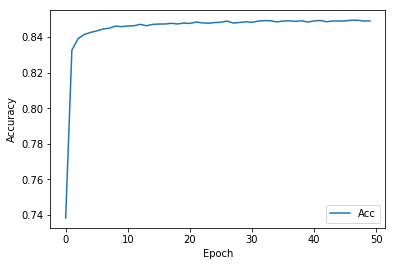

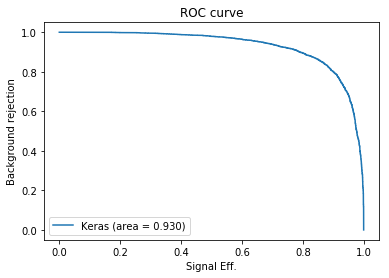

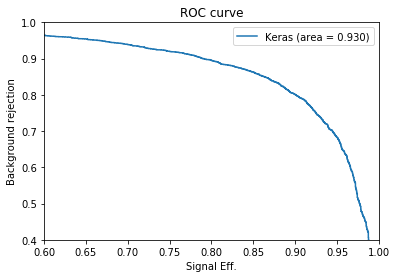

In [33]:
##### plot accuracy history
plot_history(history)

# Plot ROC curve
y_pred_keras = model.predict(test_dataset)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
#plt.plot([0.6, 1], [0.95, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.xlim(0.6, 1)
plt.ylim(0.4, 1)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()